In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('techgems2_with_addresses.csv')

# Basic info
print(f"Total records: {len(df)}")
print(f"Missing Crime IDs: {df['Crime ID'].isna().sum()}")


Total records: 511
Missing Crime IDs: 80


In [52]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm


In [53]:
# Handle missing values
missing_count = df['Crime ID'].isna().sum()

# Generate new IDs only for missing values
if missing_count > 0:
    # Create new IDs for missing values
    new_ids = ['GEN_' + str(i) for i in range(1, missing_count + 1)]
    # Assign them to the missing positions
    df.loc[df['Crime ID'].isna(), 'Crime ID'] = new_ids

# For location data, drop rows with missing coordinates
df = df.dropna(subset=['Longitude', 'Latitude'])

# For other categorical columns, fill with 'Unknown'
df['Last outcome category'] = df['Last outcome category'].fillna('Unknown')

# Convert Month to datetime
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
df = df.dropna(subset=['Month'])
df = df.iloc[:, :-1]

# Verify no missing values remain
print(f"\nCleaned dataset shape: {df.shape}")
print("\nMissing values after cleaning:")
print(df.isna().sum())


Cleaned dataset shape: (479, 10)

Missing values after cleaning:
Crime ID                 0
Month                    0
Reported by              0
Falls with               0
Longitude                0
Latitude                 0
Location                 0
LSOA code                0
Crime type               0
Last outcome category    0
dtype: int64


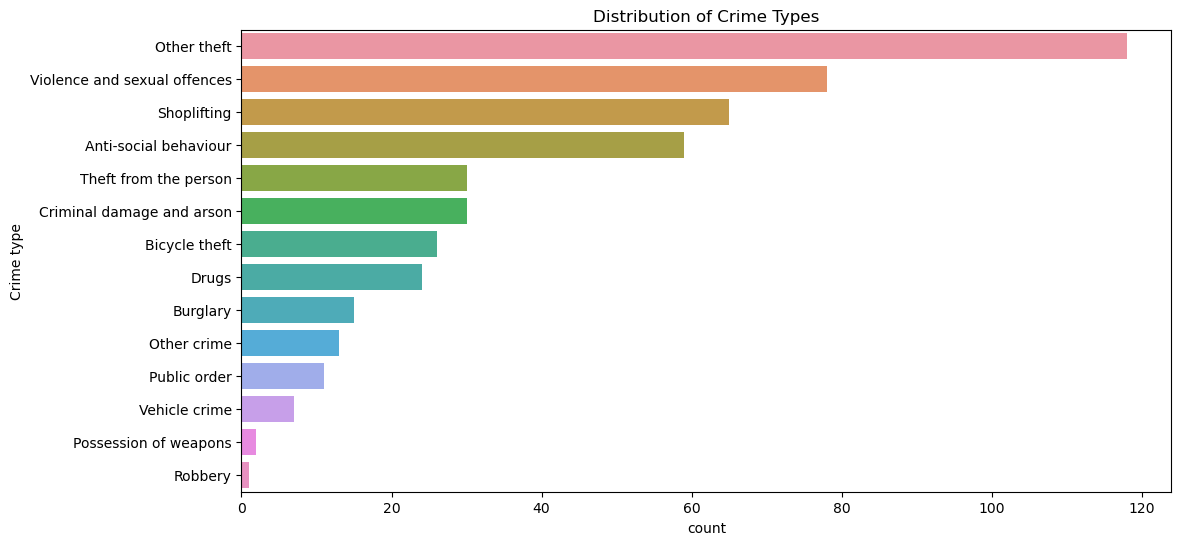

In [54]:

# Crime type distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Crime type', data=df, order=df['Crime type'].value_counts().index)
plt.title('Distribution of Crime Types')
plt.show()

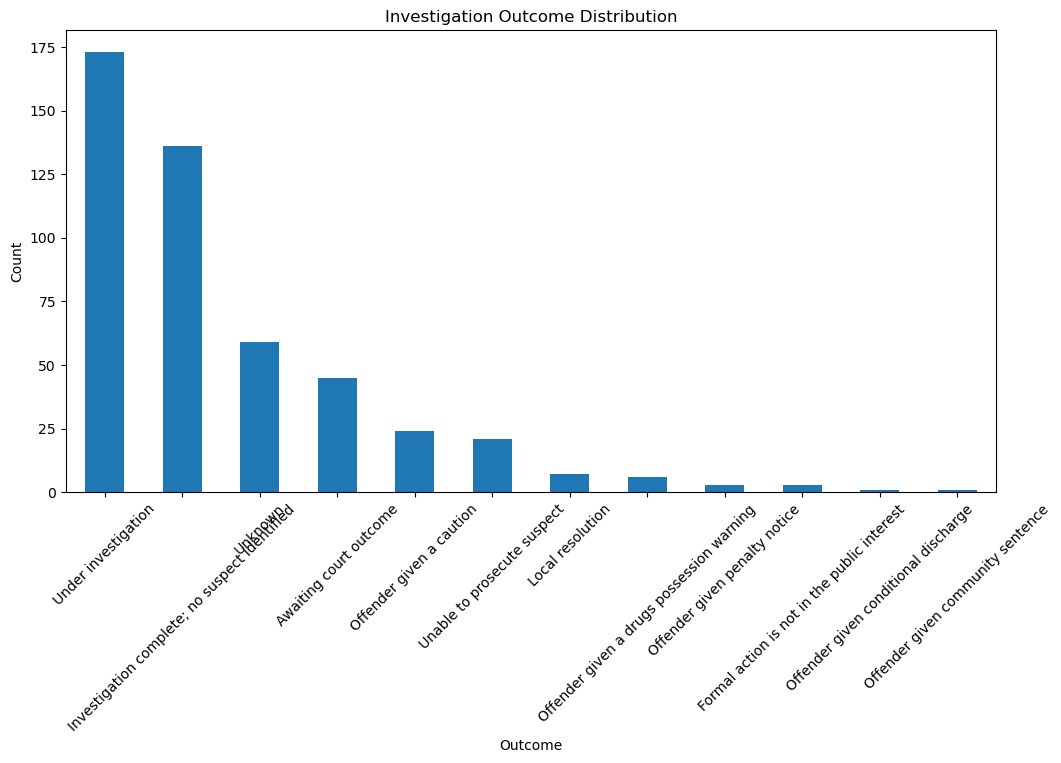

In [55]:
# Outcome distribution
outcome_counts = df['Last outcome category'].value_counts()
plt.figure(figsize=(12,6))
outcome_counts.plot(kind='bar')
plt.title('Investigation Outcome Distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

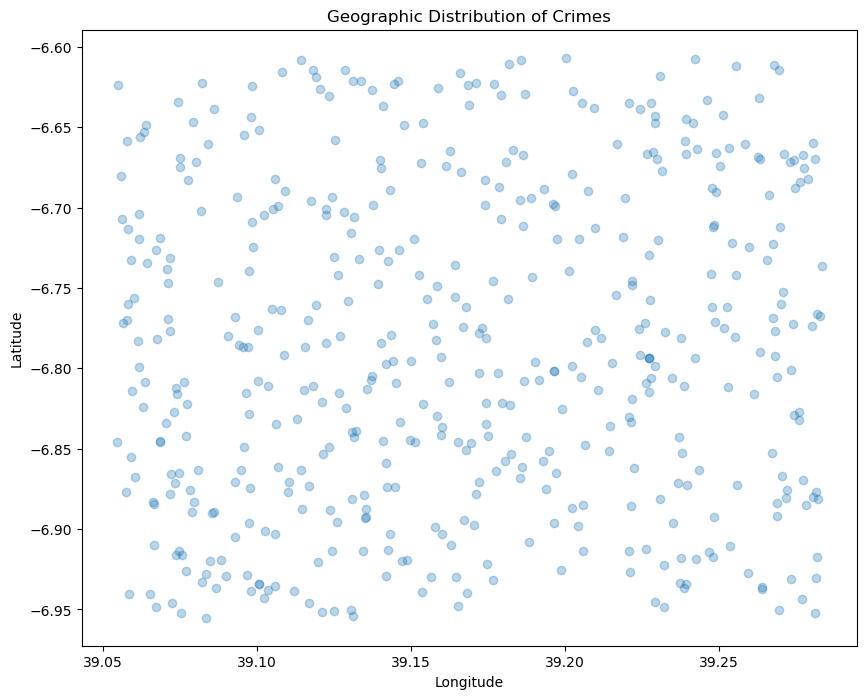

In [56]:
# Geographic distribution
plt.figure(figsize=(10,8))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.3)
plt.title('Geographic Distribution of Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [57]:
# Feature Engineering
def extract_municipality(location):
    if 'Ilala Municipal' in location: return 'Ilala'
    elif 'Kinondoni Municipal' in location: return 'Kinondoni'
    elif 'Temeke MC' in location: return 'Temeke'
    elif 'Ubungo Municipal' in location: return 'Ubungo'
    else: return 'Other'

df['Municipality'] = df['Location'].apply(extract_municipality)


In [58]:
# Calculate crime frequencies by municipality
crime_freq = df.groupby(['Municipality', 'Crime type']).size().unstack().fillna(0)
crime_freq_normalized = crime_freq.div(crime_freq.sum(axis=1), axis=0)
crime_freq_normalized

Crime type,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
Municipality,,,,,,,,,,,,,,
Ilala,0.127119,0.042373,0.033898,0.067797,0.033898,0.008475,0.211864,0.008475,0.016949,0.000000,0.211864,0.084746,0.016949,0.135593
Kinondoni,0.153226,0.040323,0.040323,0.056452,0.088710,0.024194,0.201613,0.000000,0.048387,0.000000,0.112903,0.040323,0.024194,0.169355
Other,0.064516,0.064516,0.032258,0.096774,0.064516,0.032258,0.129032,0.032258,0.000000,0.032258,0.258065,0.000000,0.000000,0.193548
Temeke,0.205128,0.025641,0.025641,0.000000,0.025641,0.076923,0.333333,0.000000,0.051282,0.000000,0.025641,0.076923,0.000000,0.153846
Ubungo,0.089820,0.077844,0.023952,0.071856,0.035928,0.029940,0.305389,0.000000,0.005988,0.000000,0.101796,0.071856,0.011976,0.173653


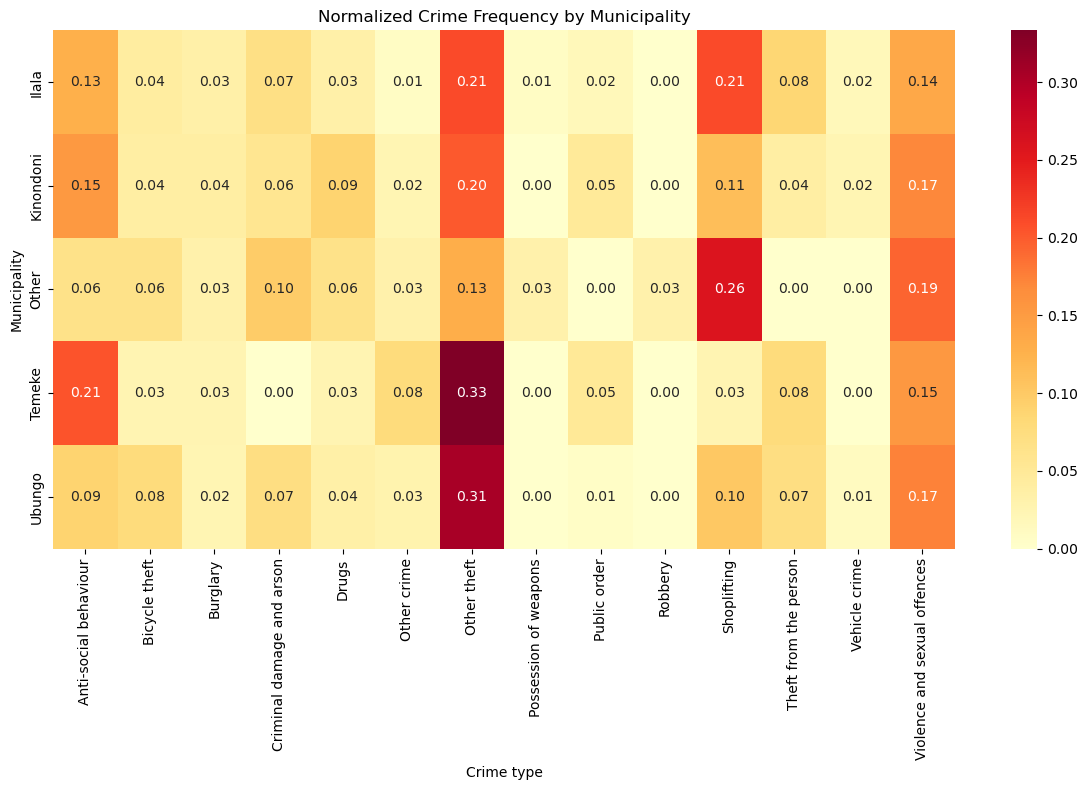

In [59]:
# Visualize crime distribution
plt.figure(figsize=(12, 8))
sns.heatmap(crime_freq_normalized, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Normalized Crime Frequency by Municipality')
plt.tight_layout()
#plt.show

In [60]:
import numpy as np
from sklearn.cluster import DBSCAN

def detect_hotspots(coords, eps=0.01, min_samples=5):
    # Validate coordinates
    if len(coords) == 0:
        print("Empty coordinates list.")
        return []

    try:
        coords = np.array(coords, dtype=np.float64)
    except Exception as e:
        print("Coordinate conversion error:", e)
        print("Original coords:", coords)
        return []

    # Remove any rows with NaN or inf values
    coords = coords[~np.isnan(coords).any(axis=1)]
    coords = coords[~np.isinf(coords).any(axis=1)]

    if coords.shape[0] == 0:
        print("No valid coordinates after cleaning.")
        return []

    print(f"Running DBSCAN on {len(coords)} points")

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    try:
        clusters = dbscan.fit_predict(coords)
    except Exception as e:
        print("DBSCAN error:", e)
        print("Coords passed to DBSCAN:", coords)
        return []

    hotspot_info = []
    for cluster_id in set(clusters):
        if cluster_id == -1:  # Noise
            continue
        mask = clusters == cluster_id
        center = coords[mask].mean(axis=0)
        size = mask.sum()
        hotspot_info.append({
            'center_lon': center[0],
            'center_lat': center[1],
            'size': size,
            'points': coords[mask]
        })

    return hotspot_info


In [61]:
# First prepare your coordinates properly
coordinates = df[['Longitude', 'Latitude']].values

# Then call the function
hotspots = detect_hotspots(coordinates)

# You can also analyze by crime type
hotspots_db = {}
for crime_type in df['Crime type'].unique():
    # Get coordinates for this crime type
    coords = df[df['Crime type'] == crime_type][['Longitude', 'Latitude']].values
    hotspots = detect_hotspots(coords)
    if hotspots:  # Only store if hotspots were found
        hotspots_db[crime_type] = hotspots

Running DBSCAN on 479 points
Running DBSCAN on 30 points
Running DBSCAN on 118 points
Running DBSCAN on 59 points
Running DBSCAN on 26 points
Running DBSCAN on 30 points
Running DBSCAN on 78 points
Running DBSCAN on 24 points
Running DBSCAN on 11 points
Running DBSCAN on 7 points
Running DBSCAN on 1 points
Running DBSCAN on 13 points
Running DBSCAN on 15 points
Running DBSCAN on 2 points
Running DBSCAN on 65 points


In [62]:
# Visualize some hotspots
sample_crime = list(hotspots_db.keys())[0]
plt.figure(figsize=(10, 8))
for hotspot in hotspots_db[sample_crime]:
    plt.scatter(hotspot['points'][:, 0], hotspot['points'][:, 1], 
                s=50, alpha=0.5, label=f'Hotspot (size: {hotspot["size"]})')
plt.title(f'Hotspots for {sample_crime}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.savefig(f'hotspots_{sample_crime.replace("/", "_")}.png')
plt.close()

# Save hotspots
joblib.dump(hotspots_db, 'crime_hotspots.pkl')
# def visualize_hotspots(hotspots_db, save_dir='hotspot_visualizations'):
#     """
#     Visualize crime hotspots using matplotlib and interactive folium maps
    
#     Parameters:
#     - hotspots_db: Dictionary containing hotspot data (output from detect_hotspots)
#     - save_dir: Directory to save visualizations
#     """
    
#     # Create directory if it doesn't exist
#     os.makedirs(save_dir, exist_ok=True)
    
#     # 1. Matplotlib Visualizations (static images)
#     print("Creating static hotspot visualizations...")
#     for crime_type, hotspots in hotspots_db.items():
#         if not hotspots:  # Skip if no hotspots for this crime type
#             continue
            
#         plt.figure(figsize=(12, 10))
        
#         # Plot all points in light gray
#         all_lons = [point[0] for hotspot in hotspots for point in hotspot['points']]
#         all_lats = [point[1] for hotspot in hotspots for point in hotspot['points']]
#         plt.scatter(all_lons, all_lats, c='lightgray', s=10, alpha=0.3, label='Individual crimes')
        
#         # Plot hotspots with different colors
#         colors = plt.cm.get_cmap('tab20', len(hotspots))
#         for i, hotspot in enumerate(hotspots):
#             plt.scatter(hotspot['points'][:, 0], hotspot['points'][:, 1],
#                         s=50, alpha=0.6, color=colors(i),
#                         label=f'Hotspot {i+1} (size: {hotspot["size"]})')
#             plt.scatter(hotspot['center_lon'], hotspot['center_lat'],
#                         s=200, marker='x', color='red', linewidths=2)
        
#         plt.title(f'Hotspots for {crime_type} (Total: {len(hotspots)})')
#         plt.xlabel('Longitude')
#         plt.ylabel('Latitude')
#         plt.grid(True, alpha=0.3)
#         plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#         plt.tight_layout()
        
#         # Save the figure
#         safe_name = crime_type.replace('/', '_').replace('\\', '_')
#         plt.savefig(f'{save_dir}/hotspots_{safe_name}.png', dpi=300, bbox_inches='tight')
#         plt.close()
    
#     # 2. Interactive Folium Maps
#     print("Creating interactive hotspot maps...")
#     for crime_type, hotspots in hotspots_db.items():
#         if not hotspots:
#             continue
            
#         # Create base map centered on the mean of all points
#         mean_lat = np.mean([point[1] for hotspot in hotspots for point in hotspot['points']])
#         mean_lon = np.mean([point[0] for hotspot in hotspots for point in hotspot['points']])
#         m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)
        
#         # Add marker clusters for all crimes
#         marker_cluster = MarkerCluster().add_to(m)
#         for hotspot in hotspots:
#             for point in hotspot['points']:
#                 folium.CircleMarker(
#                     location=[point[1], point[0]],
#                     radius=3,
#                     color='blue',
#                     fill=True,
#                     fill_color='blue',
#                     fill_opacity=0.4
#                 ).add_to(marker_cluster)
        
#         # Add hotspots as circles
#         for i, hotspot in enumerate(hotspots):
#             folium.Circle(
#                 location=[hotspot['center_lat'], hotspot['center_lon']],
#                 radius=hotspot['size']*10,  # Scale radius by hotspot size
#                 color='red',
#                 fill=True,
#                 fill_color='red',
#                 fill_opacity=0.2,
#                 popup=f'Hotspot {i+1}<br>Size: {hotspot["size"]} crimes'
#             ).add_to(m)
        
#         # Save the interactive map
#         safe_name = crime_type.replace('/', '_').replace('\\', '_')
#         m.save(f'{save_dir}/interactive_hotspots_{safe_name}.html')
    
#     # 3. Summary statistics
#     print("\nHotspot Summary Statistics:")
#     for crime_type, hotspots in hotspots_db.items():
#         if hotspots:
#             total_crimes = sum(h['size'] for h in hotspots)
#             print(f"{crime_type}:")
#             print(f"  - Number of hotspots: {len(hotspots)}")
#             print(f"  - Total crimes in hotspots: {total_crimes}")
#             print(f"  - Avg crimes per hotspot: {total_crimes/len(hotspots):.1f}")
#             print(f"  - Largest hotspot: {max(h['size'] for h in hotspots)} crimes")
    
#     # Save hotspots data
#     joblib.dump(hotspots_db, f'{save_dir}/crime_hotspots.pkl')
#     print(f"\nAll visualizations saved to '{save_dir}' directory")

# # Example usage:
# # visualize_hotspots(hotspots_by_type)

['crime_hotspots.pkl']

In [63]:
import folium

def visualize_hotspots(hotspots):
    # Create a base map centered at the first hotspot (or your choice of location)
    if len(hotspots) == 0:
        print("No hotspots to display.")
        return
    
    # Initialize the map at the first hotspot's coordinates
    first_hotspot = hotspots[0]
    map_center = [first_hotspot['center_lat'], first_hotspot['center_lon']]
    crime_map = folium.Map(location=map_center, zoom_start=12)

    # Add a marker for each hotspot
    for hotspot in hotspots:
        folium.Marker(
            location=[hotspot['center_lat'], hotspot['center_lon']],
            popup=folium.Popup(f"Size: {hotspot['size']} points", max_width=200)
        ).add_to(crime_map)
    
    # Save the map as an HTML file
    crime_map.save("hotspots_map.html")
    print("Hotspot map saved as hotspots_map.html")

# Example usage with the detected hotspots
for crime_type, hotspots in hotspots_db.items():
    print(f"Visualizing hotspots for crime type: {crime_type}")
    visualize_hotspots(hotspots)


Visualizing hotspots for crime type: Other theft
Hotspot map saved as hotspots_map.html


In [64]:
# Prepare training data for location-specific risk prediction
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df), desc='Preparing Features'):
    # Feature 1: Municipality
    municipality = row['Municipality']
    
    # Feature 2: Crime type
    crime_type = row['Crime type']
    
    # Feature 3: Nearby crime density
    nearby_crimes = df[
        (df['Longitude'].between(row['Longitude']-0.02, row['Longitude']+0.02)) &
        (df['Latitude'].between(row['Latitude']-0.02, row['Latitude']+0.02))
    ]
    crime_density = len(nearby_crimes)
     # Feature 4: Hotspot proximity
    hotspot_proximity = 0
    if crime_type in hotspots_db:
        for hotspot in hotspots_db[crime_type]:
            distance = np.sqrt((hotspot['center_lon']-row['Longitude'])**2 + 
                             (hotspot['center_lat']-row['Latitude'])**2)
            if distance < 0.02:  # ~2km
                hotspot_proximity = max(hotspot_proximity, hotspot['size'])
    
    # Target: Risk level (we'll use normalized crime frequency as proxy)
    risk_level = crime_freq_normalized.loc[municipality, crime_type] if crime_type in crime_freq_normalized.columns else 0
    
    X.append([municipality, crime_type, crime_density, hotspot_proximity])
    y.append(risk_level)


Preparing Features: 100%|███████████████████████████████████████████████████████████| 479/479 [00:00<00:00, 555.86it/s]


In [65]:
# Encode categorical features
le_municipality = LabelEncoder()
le_crime = LabelEncoder()

X_encoded = np.array(X)
X_encoded[:, 0] = le_municipality.fit_transform(X_encoded[:, 0])
X_encoded[:, 1] = le_crime.fit_transform(X_encoded[:, 1])
X_encoded = X_encoded.astype(float)

# Convert risk to categories
y_cat = pd.cut(y, bins=[-0.1, 0.1, 0.3, 1.0], labels=['Low', 'Medium', 'High'])


In [66]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_cat, test_size=0.2, random_state=42)

model2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model2.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

In [67]:
from sklearn.metrics import confusion_matrix

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.close()


Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        14
         Low       1.00      0.92      0.96        36
      Medium       0.94      1.00      0.97        46

    accuracy                           0.97        96
   macro avg       0.98      0.97      0.97        96
weighted avg       0.97      0.97      0.97        96



<function matplotlib.pyplot.show(close=None, block=None)>

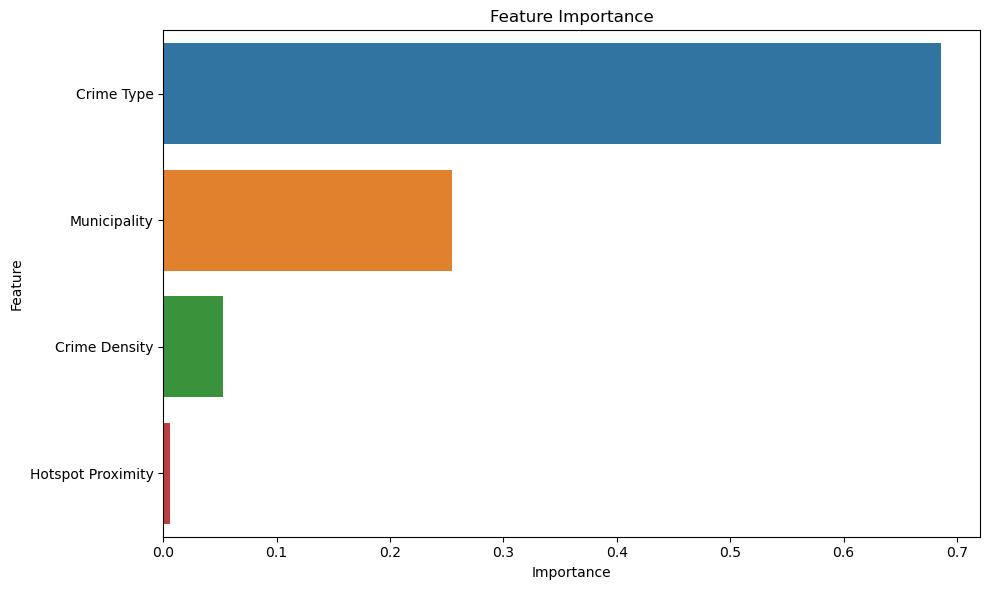

In [68]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Municipality', 'Crime Type', 'Crime Density', 'Hotspot Proximity'],
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show


In [69]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

def geocode_address(address):
    """Convert address to latitude/longitude using Nominatim"""
    geolocator = Nominatim(user_agent="crime_risk_predictor")
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            raise ValueError("Address not found. Try a more specific location.")
    except (GeocoderTimedOut, GeocoderUnavailable):
        raise ConnectionError("Geocoding service unavailable. Try again later.")

def predict_risk_level(address, crime_type):
    """Predict risk level for a given address"""
    # Step 1: Geocode the address to get (latitude, longitude)
    try:
        latitude, longitude = geocode_address(address)
    except Exception as e:
        return {"error": str(e)}
    
    # Step 2: Create feature vector
    features = pd.DataFrame({
        'Longitude': [longitude],
        'Latitude': [latitude],
        'Crime type': [crime_type]
    })
    
    # Step 3: One-hot encode
    features = pd.get_dummies(features)
    
    # Ensure all training columns are present
    for col in X_train.columns:
        if col not in features.columns:
            features[col] = 0
    
    # Reorder columns to match training data
    features = features[X_train.columns]
    
    # Step 4: Predict
    proba = rf.predict_proba(features)[0]
    prediction = rf.predict(features)[0]
    
    return {
        'address': address,
        'latitude': latitude,
        'longitude': longitude,
        'crime_type': crime_type,
        'high_risk_probability': float(proba[1]),  # Convert numpy.float to Python float
        'risk_level': 'High' if prediction == 1 else 'Low'
    }

In [70]:
import joblib

# Save your trained model
joblib.dump(model2, 'crime/myapp/ml/model2.pkl')


['crime/myapp/ml/model2.pkl']